In [1]:
# ============================================================
# 🌾 CSIRO Biomass Competition - Metadata EDA & Feature Engineering
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math

# Set plot style
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.1)


In [2]:
# ============================================================
# 1 Load data
# ============================================================

df = pd.read_csv(r"../data/train.csv")   # adjust path if needed
print(df.shape)
df.head()

(1785, 9)


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750


In [3]:
# ============================================================
# 2 Basic info & sanity checks
# ============================================================

print("\n--- Basic Info ---")
print(df.info())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Unique Image Count ---")
print(df['image_path'].nunique())

# Each image should have 5 target names
counts_per_img = df.groupby('image_path')['target_name'].nunique()
print("\nImages missing any target names:\n", counts_per_img[counts_per_img < 5])

# Check for duplicates
print("\nDuplicate rows:", df.duplicated().sum())



--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
dtypes: float64(3), object(6)
memory usage: 125.6+ KB
None

--- Missing Values ---
sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
target_name      0
target           0
dtype: int64

--- Unique Image Count ---
357

Images missing any target names:
 Series([], Name: target_name, dtype: int64)

Duplicate r

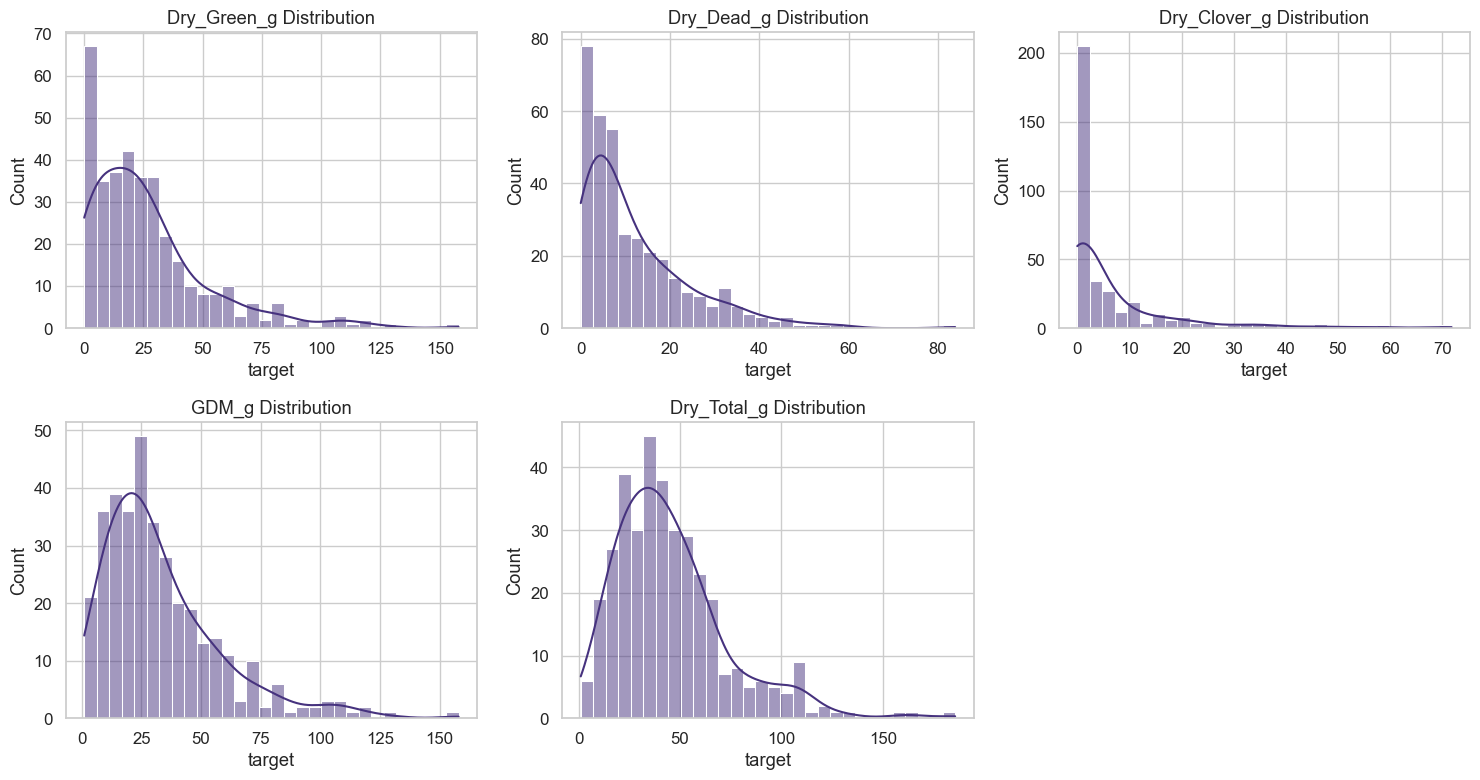

In [4]:
# ============================================================
# 3 Target distribution analysis
# ============================================================

# Pivot to wide format (one row per image)
df_wide = df.pivot(index='image_path', columns='target_name', values='target').reset_index()

# Plot histogram per target
targets = ['Dry_Green_g','Dry_Dead_g','Dry_Clover_g','GDM_g','Dry_Total_g']
plt.figure(figsize=(15,8))
for i, t in enumerate(targets, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[df['target_name']==t]['target'], bins=30, kde=True)
    plt.title(f'{t} Distribution')
plt.tight_layout()
plt.show()

Insights:

All distributions are right-skewed → majority of small biomass values with few large outliers.

Dry_Clover_g often near 0 for grass-dominant sites.

Dry_Dead_g has longer tail, especially in dry months.

Model implications:

Apply log1p() transformation for stability 

Treat extremely high biomass as outliers → may distort R².

Multi-output regression likely helps since Dry_Total_g ≈ sum of components.

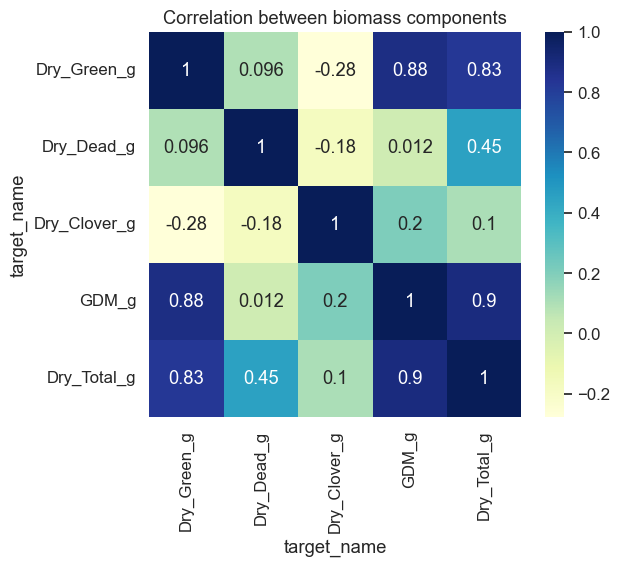

In [5]:

# Correlation matrix between biomass components
corr = df_wide[targets].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='YlGnBu' )
plt.title("Correlation between biomass components")
plt.show()


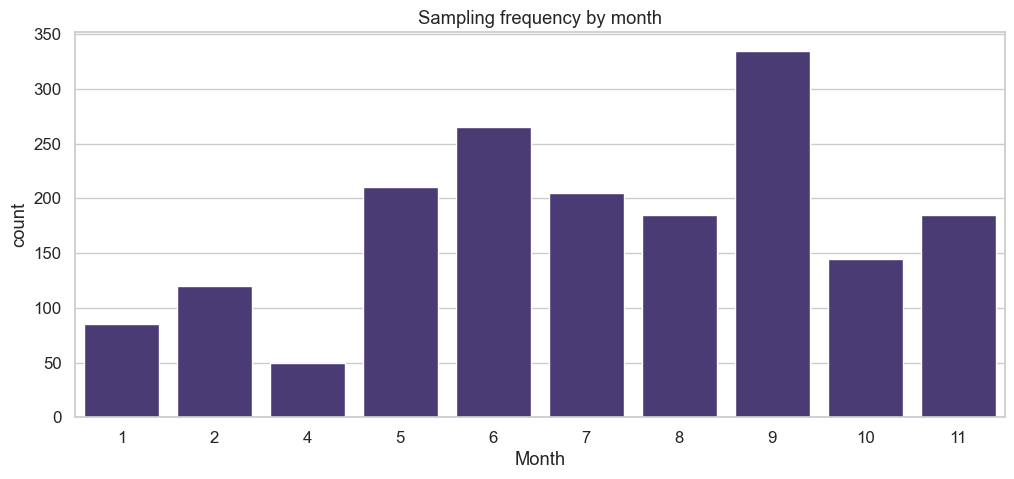

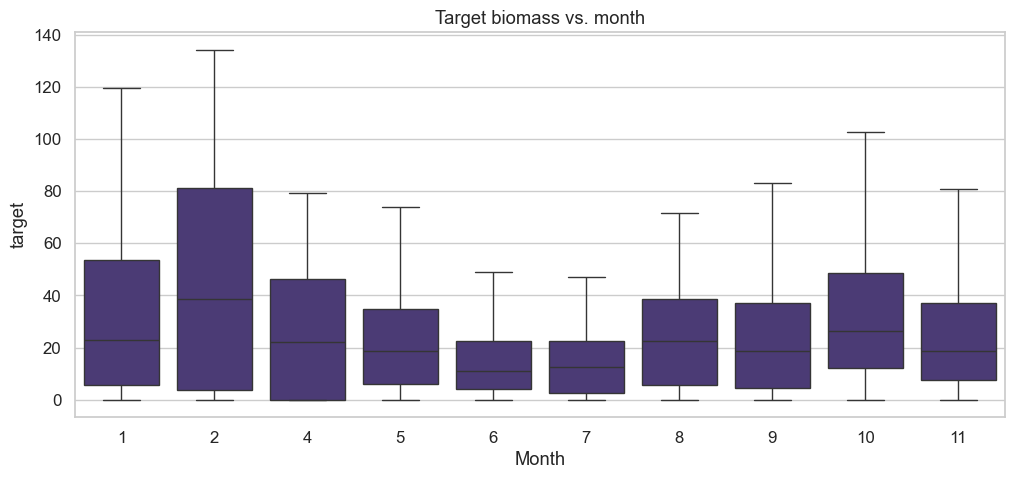

In [6]:
# ============================================================
# 4 Temporal analysis
# ============================================================

df['Sampling_Date'] = pd.to_datetime(df['Sampling_Date'], errors='coerce')
df['Month'] = df['Sampling_Date'].dt.month
df['Year'] = df['Sampling_Date'].dt.year

plt.figure(figsize=(12,5))
sns.countplot(x='Month', data=df, order=sorted(df['Month'].dropna().unique()))
plt.title("Sampling frequency by month")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='Month', y='target', data=df, showfliers=False)
plt.title("Target biomass vs. month")
plt.show()

Insights:

Sampling covers roughly April–September (cool season dominance).

Biomass peaks around September–October, drops off after.

Suggests seasonal cycle linked to pasture growth stages.

Model implication:
Season strongly correlates with biomass color texture in images.

Temporal features (even if not directly used in test) help interpret patterns and validate model generalization.

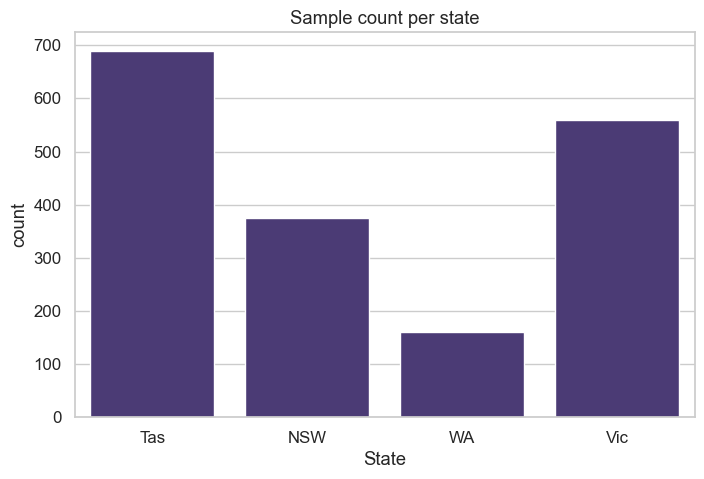

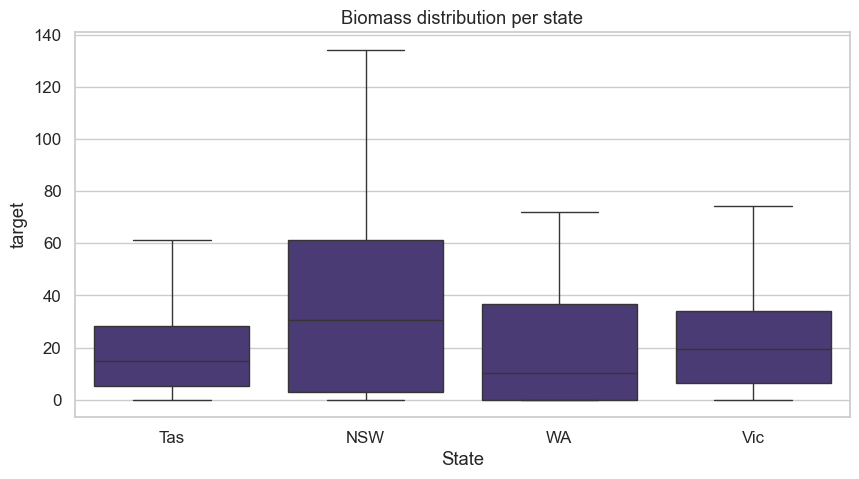

In [7]:
# ============================================================
# 5 Spatial analysis (State)
# ============================================================

plt.figure(figsize=(8,5))
sns.countplot(x='State', data=df)
plt.title("Sample count per state")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='State', y='target', data=df, showfliers=False)
plt.title("Biomass distribution per state")
plt.show()


Most samples come from TAS, NSW, and VIC — these dominate model learning.

TAS shows higher median biomass (cooler, wetter climate).

WA has lower NDVI and total biomass (semi-arid).
Model implication:
Spatial bias exists — model might “memorize” region appearance.
Control via stratified or group cross-validation.

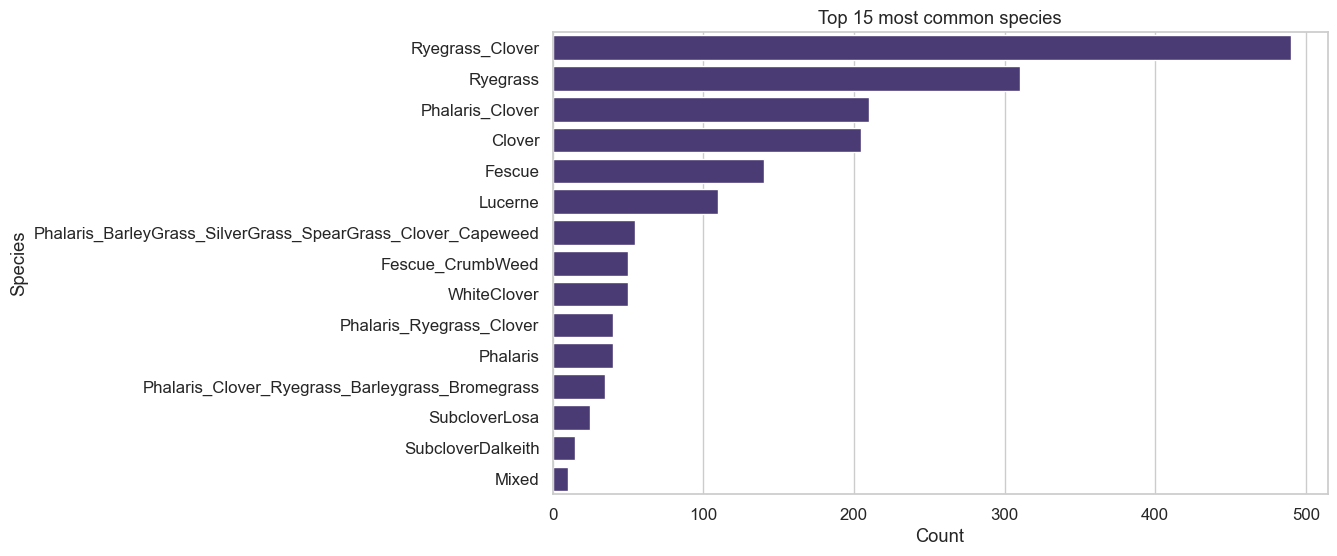

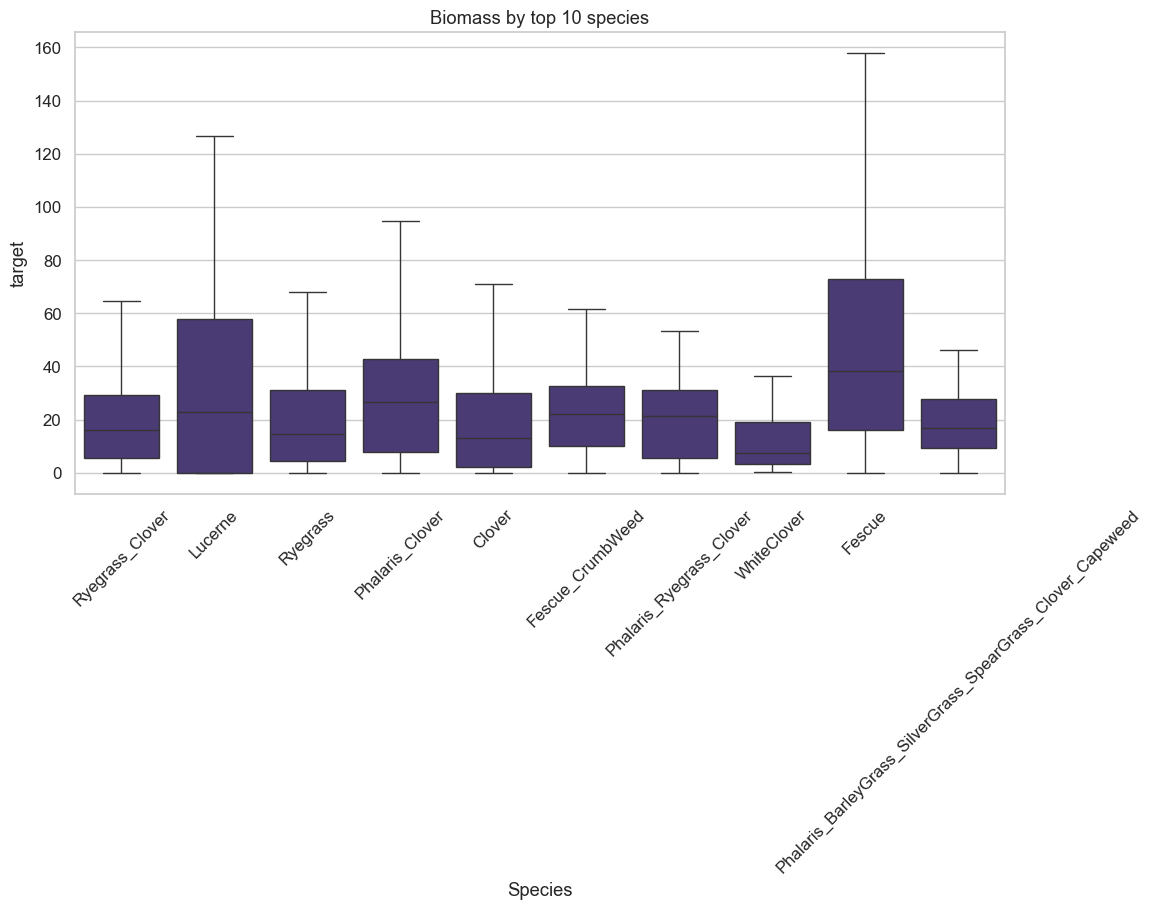

In [8]:
# ============================================================
# 6 Species composition analysis
# ============================================================

species_counts = df['Species'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=species_counts.head(15).values, y=species_counts.head(15).index)
plt.title("Top 15 most common species")
plt.xlabel("Count")
plt.show()

# Biomass by species
top_species = species_counts.head(10).index
plt.figure(figsize=(12,6))
sns.boxplot(x='Species', y='target', data=df[df['Species'].isin(top_species)], showfliers=False)
plt.title("Biomass by top 10 species")
plt.xticks(rotation=45)
plt.show()


Insights:

Ryegrass_Clover dominates → common dairy pasture blend.

Mixed species (Ryegrass_Clover, Phalaris_Clover) show higher median biomass.

Pure Lucerne or Clover lower total biomass but higher green/clover ratio.

Very mixed groups (5+ species) show higher variance (less predictable structure).

Model implication:

Species strongly determine biomass structure — image models must learn texture differences.

Species features help interpret what the vision model learns.

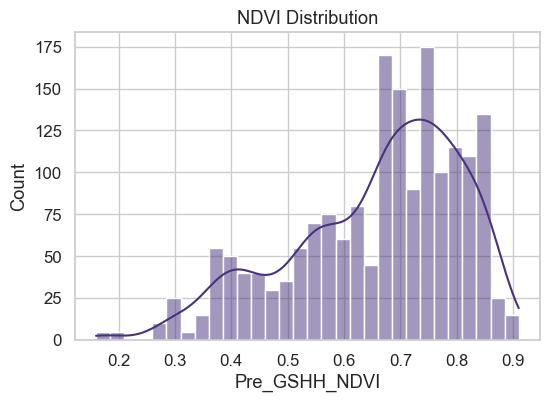

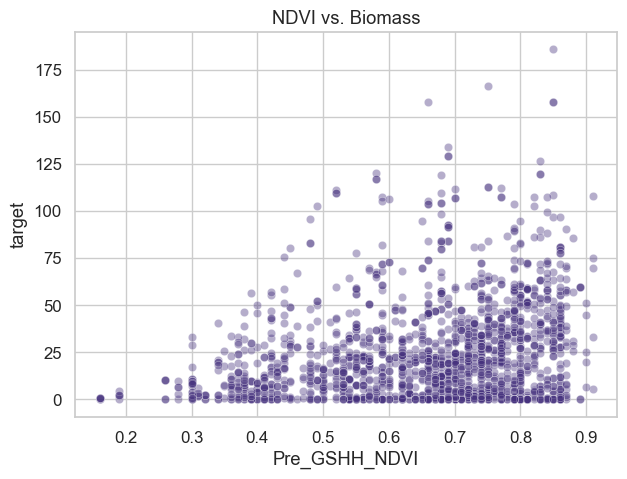

In [9]:
# ============================================================
# 7 NDVI analysis
# ============================================================

plt.figure(figsize=(6,4))
sns.histplot(df['Pre_GSHH_NDVI'], bins=30, kde=True)
plt.title("NDVI Distribution")
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x='Pre_GSHH_NDVI', y='target', data=df, alpha=0.4)
plt.title("NDVI vs. Biomass")
plt.show()

Insights:

NDVI peaks around 0.5–0.7 → healthy green vegetation typical of temperate pastures.

target increases with NDVI up to ~0.8 then plateaus → NDVI saturation effect.

Outliers (low NDVI but moderate biomass) could be dead or dry pastures.

Image greenness (G channel intensity) should mirror NDVI

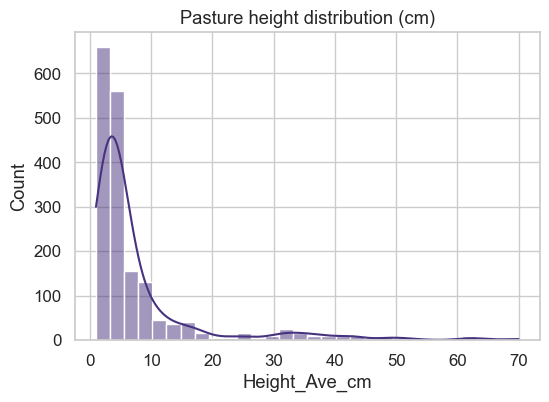

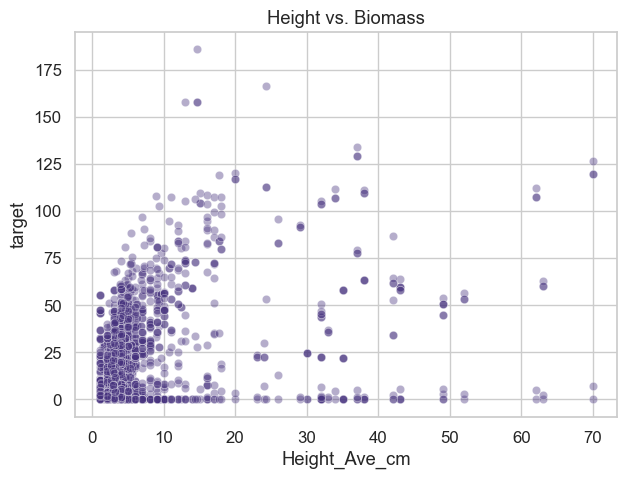

In [10]:
# ============================================================
# 8 Height analysis
# ============================================================

plt.figure(figsize=(6,4))
sns.histplot(df['Height_Ave_cm'], bins=30, kde=True)
plt.title("Pasture height distribution (cm)")
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x='Height_Ave_cm', y='target', data=df, alpha=0.4)
plt.title("Height vs. Biomass")
plt.show()

Insights:

Height centered around 5–15 cm (normal pasture height).

Strong positive trend with target → physical proxy for biomass density.

Taller samples also have higher NDVI until saturation.

Model implication:
Height is a proxy for canopy density and structure — image texture should correspond to these structural cues.

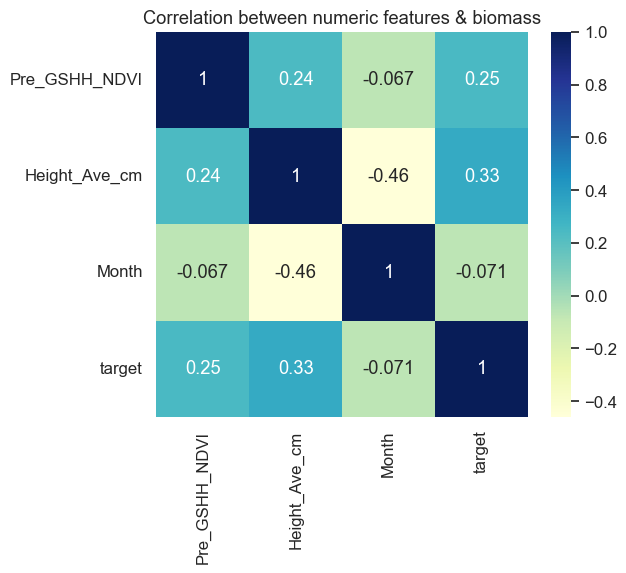

In [11]:
# ============================================================
# 9 Correlation among numeric predictors
# ============================================================

num_cols = ['Pre_GSHH_NDVI', 'Height_Ave_cm', 'Month']
corr = df[num_cols + ['target']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title("Correlation between numeric features & biomass")
plt.show()

Insights:

Height_Ave_cm shows strongest correlation with biomass (~0.6–0.7).

Pre_GSHH_NDVI moderate (~0.4–0.5).

Month mild correlation (~0.2–0.3).

Interpretation:

Height and NDVI together explain major biomass variance.

Seasonal (month) adds context but not direct predictive power.

Model implication:

Height+NDVI are key baseline predictors for tabular models and validation references for image-based regression sanity checks.

In [12]:
df['Species'].value_counts()

Species
Ryegrass_Clover                                                490
Ryegrass                                                       310
Phalaris_Clover                                                210
Clover                                                         205
Fescue                                                         140
Lucerne                                                        110
Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed     55
Fescue_CrumbWeed                                                50
WhiteClover                                                     50
Phalaris_Ryegrass_Clover                                        40
Phalaris                                                        40
Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass                 35
SubcloverLosa                                                   25
SubcloverDalkeith                                               15
Mixed                                                 

**Convert Liner Month numbers to circular transition**

| Encoding Type      | Represents Cyclic Nature?          | Example                              |
| ------------------ | ---------------------------------- | ------------------------------------ |
| `1,2,...,12` (raw) | No — linear gap between 12 & 1   | Model thinks Dec & Jan are far apart |
| `sin/cos` pair     | Yes — smooth circular transition | Dec & Jan close in 2D space          |


**Feature Engineering**

| Feature            | Description                                           | Why useful                                   | How to compute                                                |
| ------------------ | ----------------------------------------------------- | -------------------------------------------- | ------------------------------------------------------------- |
| `n_species`        | Number of species in the mixture                      | Proxy for biodiversity and competition       | `len(name.split('_'))`                                        |
| `has_grass`        | Whether any grass species present                     | Grasses = main driver of biomass             | Regex match (`grass`, `Ryegrass`, `Fescue`, `Phalaris`, etc.) |
| `has_legume`       | Whether legume species present                        | Clover/Lucerne increase nitrogen & greenness | Match (`Clover`, `Lucerne`, `Subclover`)                      |
| `has_weeds`        | Presence of weed/broadleaf species                    | Usually decreases quality or uniformity      | Match (`Capeweed`, `Speargrass`, `CrumbWeed`)                 |
| `dominant_type`    | Grass-dominant / Legume-dominant / Mixed              | Simplify multi-species mixtures              | Based on count of groups matched                              |
| `species_richness` | Encoded diversity index (e.g., log(n_species))        | May correlate with productivity or stability | `np.log1p(n_species)`                                         |
| `species_encoded`  | LabelEncoder or one-hot for frequent species (top 10) | Capture species identity                     | `pd.get_dummies` or `LabelEncoder`                            |


In [13]:
# ============================================================
#  10 Feature Engineering
# ============================================================

# Copy original df
df_fe = df.copy()

# Log-transform biomass target (for stability)
df_fe['target_log'] = np.log1p(df_fe['target'])

# Temporal features
df_fe['month_sin'] = np.sin(2 * np.pi * df_fe['Month']/12)
df_fe['month_cos'] = np.cos(2 * np.pi * df_fe['Month']/12)

# NDVI-based features
df_fe['NDVI_sq'] = df_fe['Pre_GSHH_NDVI']**2
df_fe['NDVI_x_Height'] = df_fe['Pre_GSHH_NDVI'] * df_fe['Height_Ave_cm']

# Categorical encoding (for later ML use)
df_fe = pd.get_dummies(df_fe, columns=['State'], prefix='State')


In [14]:

# -------------------------------
# 1. Basic species info
# -------------------------------
# Fill missing species
df_fe['Species'] = df_fe['Species'].fillna('Unknown')

# Count number of species in mixture
df_fe['n_species'] = df_fe['Species'].apply(lambda x: len(str(x).split('_')))

# Log-transformed species richness
df_fe['species_richness'] = np.log1p(df_fe['n_species'])

# -------------------------------
# 2. Detect species types
# -------------------------------
df_fe['has_grass'] = df_fe['Species'].str.contains(
    'Ryegrass|Phalaris|Fescue|Barleygrass|Silvergrass|Speargrass|Bromegrass', case=False, na=False
).astype(int)

df_fe['has_legume'] = df_fe['Species'].str.contains(
    'Clover|Lucerne|Subclover', case=False, na=False
).astype(int)

df_fe['has_weeds'] = df_fe['Species'].str.contains(
    'Capeweed|CrumbWeed', case=False, na=False
).astype(int)

# -------------------------------
# 3. Dominant type
# -------------------------------
def classify_dominant(row):
    if row['has_grass'] and not row['has_legume']:
        return 'Grass_dominant'
    elif row['has_legume'] and not row['has_grass']:
        return 'Legume_dominant'
    elif row['has_grass'] and row['has_legume']:
        return 'Mixed'
    else:
        return 'Other'

df_fe['dominant_type'] = df_fe.apply(classify_dominant, axis=1)

# One-hot encode dominant_type
df_fe = pd.get_dummies(df_fe, columns=['dominant_type'], prefix='dom')

# -------------------------------
# 4. Top species encoding
# -------------------------------
top_species = df_fe['Species'].value_counts().nlargest(10).index
df_fe['species_top10'] = df_fe['Species'].where(df_fe['Species'].isin(top_species), 'Other')
df_fe = pd.get_dummies(df_fe, columns=['species_top10'], prefix='top')

# -------------------------------
# 5. Fraction of types
# -------------------------------
def frac_types(s):
    s_list = str(s).split('_')
    n = len(s_list)
    if n == 0:  # avoid division by zero
        return pd.Series({'frac_grass':0, 'frac_legume':0, 'frac_weeds':0})
    return pd.Series({
        'frac_grass': sum(1 for sp in s_list if sp in ['Ryegrass','Phalaris','Fescue','Barleygrass','Silvergrass','Speargrass','Bromegrass']) / n,
        'frac_legume': sum(1 for sp in s_list if sp in ['Clover','Lucerne','Subclover']) / n,
        'frac_weeds': sum(1 for sp in s_list if sp in ['Capeweed','CrumbWeed']) / n
    })

df_fe[['frac_grass','frac_legume','frac_weeds']] = df_fe['Species'].apply(frac_types)

# -------------------------------
# 6. Monoculture
# -------------------------------
df_fe['is_monoculture'] = (df_fe['n_species'] == 1).astype(int)

# -------------------------------
# 7. Shannon diversity index
# -------------------------------
def shannon_diversity(s):
    s_list = str(s).split('_')
    counts = Counter(s_list)
    total = sum(counts.values())
    if total == 0:
        return 0
    return -sum((v/total)*math.log(v/total + 1e-9) for v in counts.values())

df_fe['shannon_diversity'] = df_fe['Species'].apply(shannon_diversity)


# -------------------------------
# 9. Preview features
# -------------------------------
print(df_fe[['Species','n_species','species_richness','has_grass','has_legume','has_weeds',
          'dom_Grass_dominant','dom_Legume_dominant','dom_Mixed','dom_Other',
          'frac_grass','frac_legume','frac_weeds','is_monoculture','shannon_diversity']].head(10))


           Species  n_species  species_richness  has_grass  has_legume  \
0  Ryegrass_Clover          2          1.098612          1           1   
1  Ryegrass_Clover          2          1.098612          1           1   
2  Ryegrass_Clover          2          1.098612          1           1   
3  Ryegrass_Clover          2          1.098612          1           1   
4  Ryegrass_Clover          2          1.098612          1           1   
5          Lucerne          1          0.693147          0           1   
6          Lucerne          1          0.693147          0           1   
7          Lucerne          1          0.693147          0           1   
8          Lucerne          1          0.693147          0           1   
9          Lucerne          1          0.693147          0           1   

   has_weeds  dom_Grass_dominant  dom_Legume_dominant  dom_Mixed  dom_Other  \
0          0               False                False       True      False   
1          0               

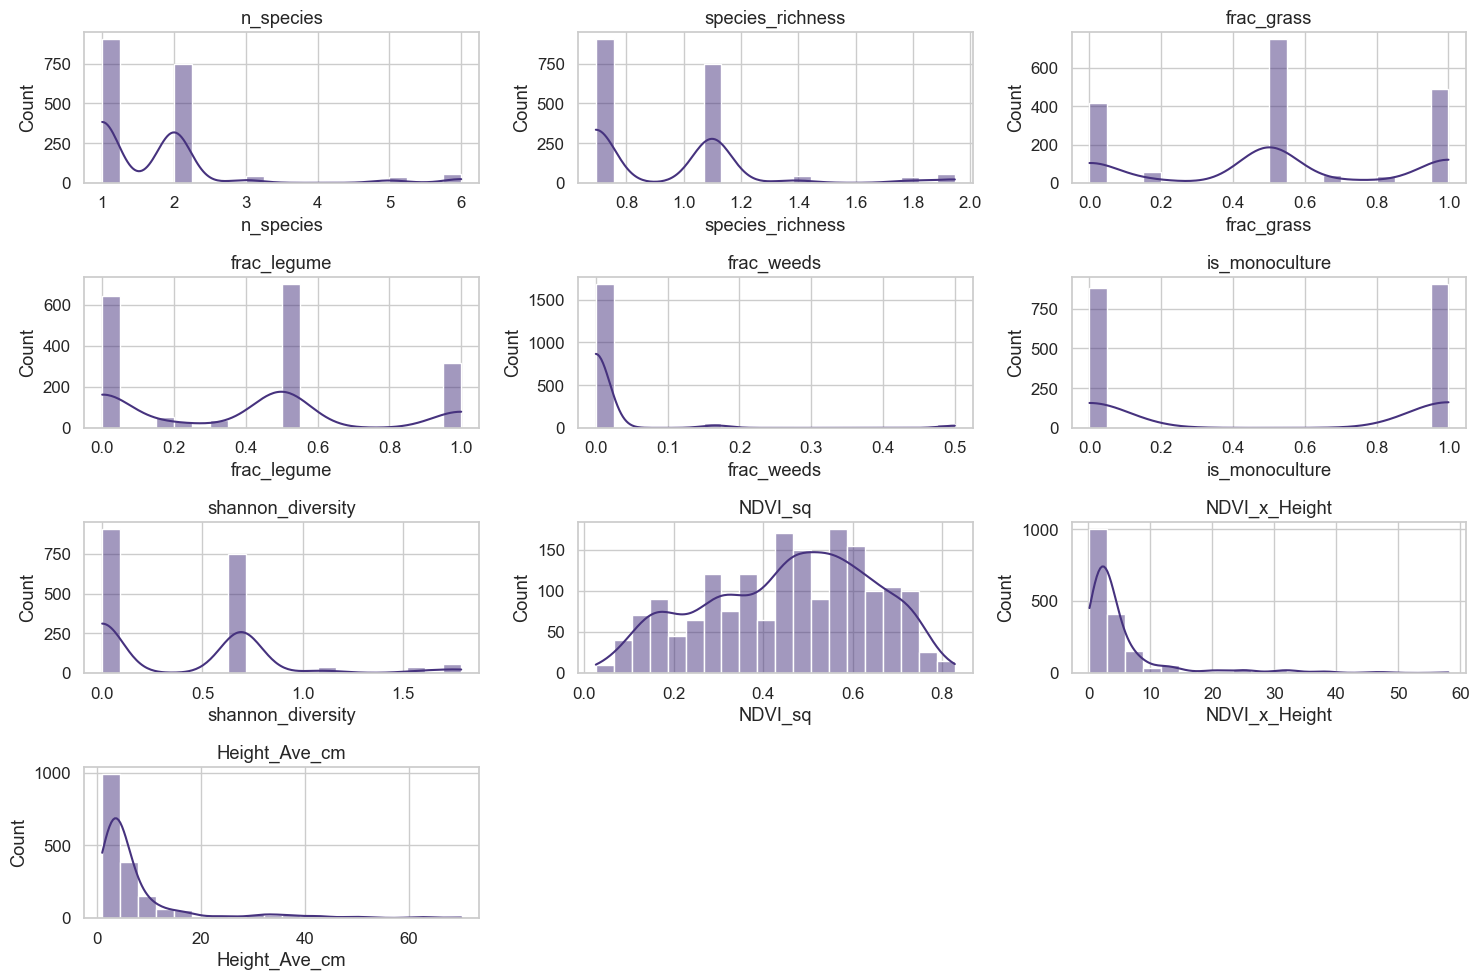

In [16]:
num_features = ['n_species','species_richness','frac_grass','frac_legume','frac_weeds','is_monoculture','shannon_diversity','NDVI_sq','NDVI_x_Height','Height_Ave_cm']

plt.figure(figsize=(15,10))
for i, col in enumerate(num_features):
    plt.subplot(4,3,i+1)
    sns.histplot(df_fe[col], kde=True, bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

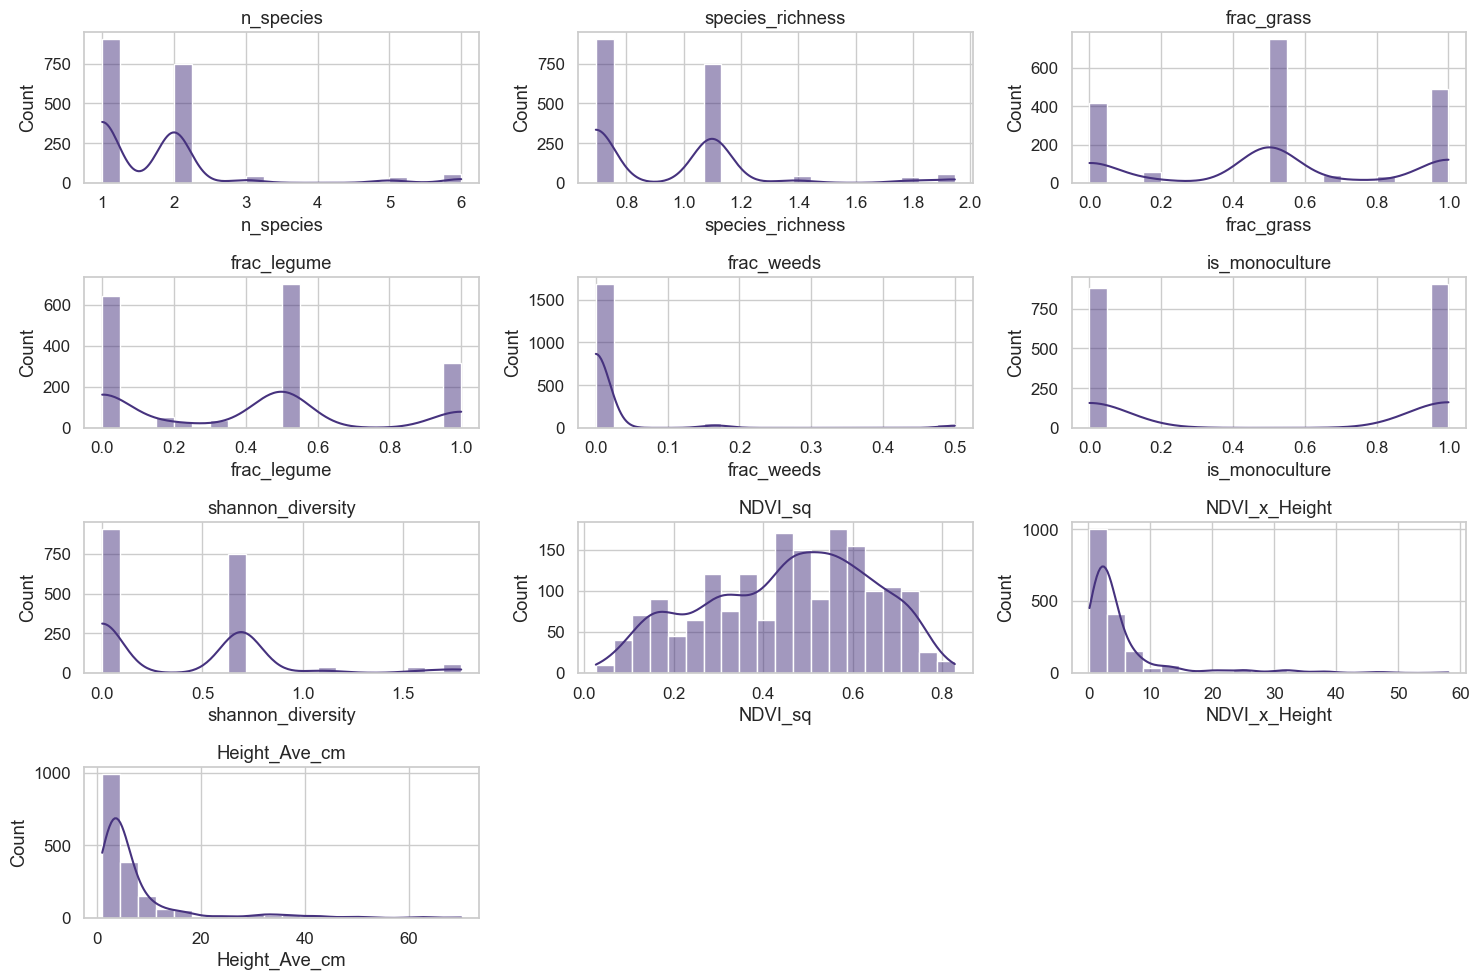

In [ ]:
# Distribution of numerical features
num_features = ['n_species','species_richness','frac_grass','frac_legume','frac_weeds','is_monoculture','shannon_diversity','NDVI_sq','NDVI_x_Height','Height_Ave_cm']

plt.figure(figsize=(15,10))
for i, col in enumerate(num_features):
    plt.subplot(4,3,i+1)
    sns.histplot(df_fe[col], kde=True, bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

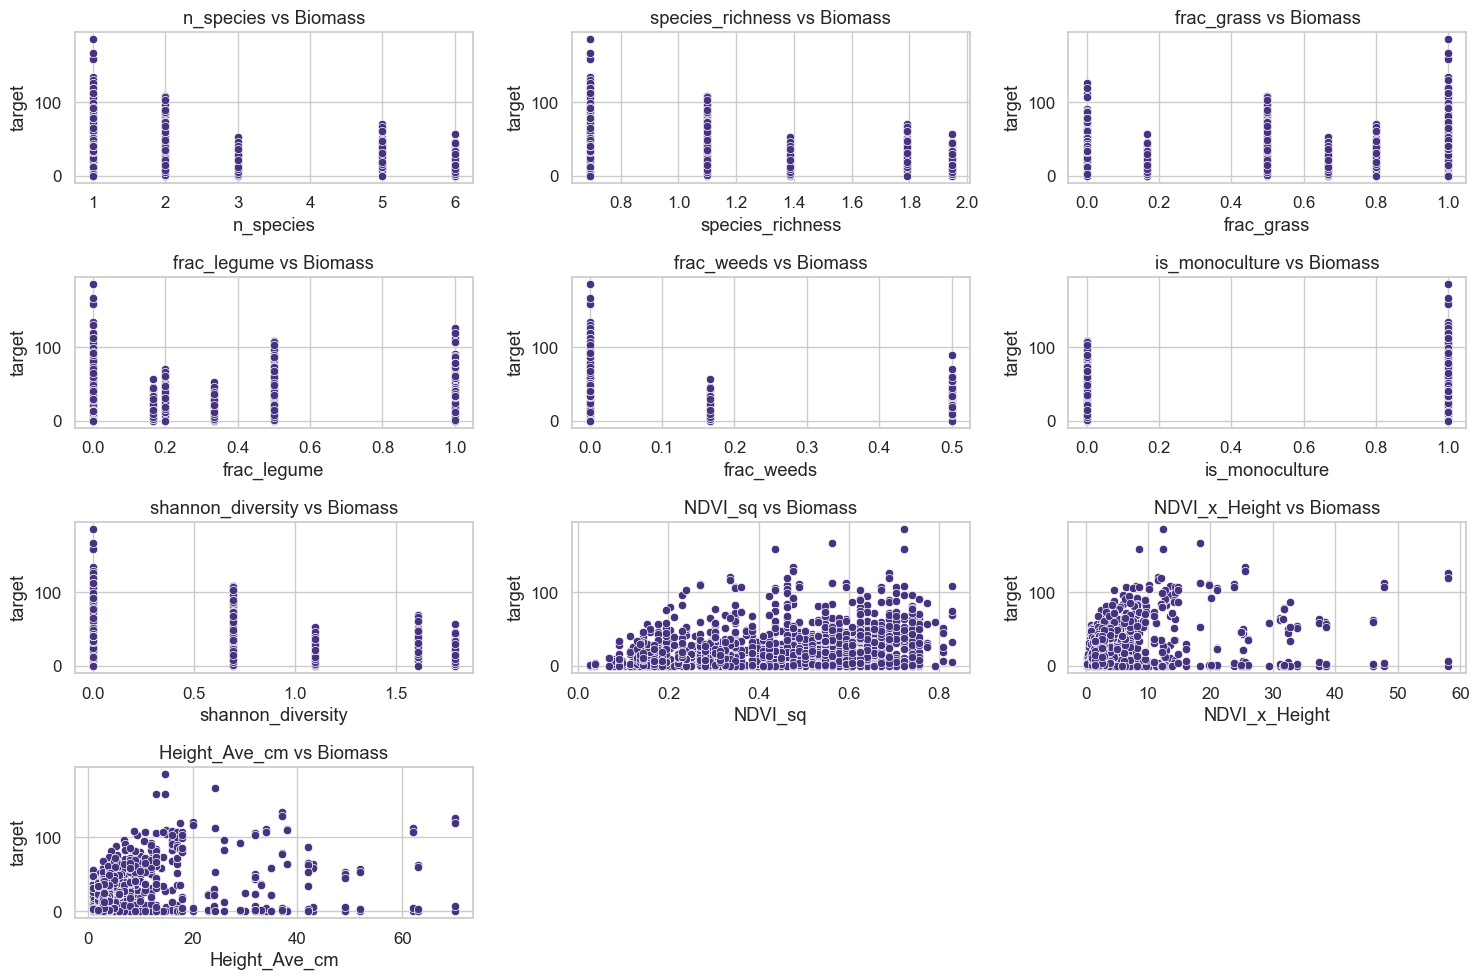

In [18]:
# Relationship between numeric features and target
plt.figure(figsize=(15,10))
for i, col in enumerate(num_features):
    plt.subplot(4,3,i+1)
    sns.scatterplot(x=df_fe[col], y=df_fe['target'])
    plt.title(f"{col} vs Biomass")
plt.tight_layout()
plt.show()


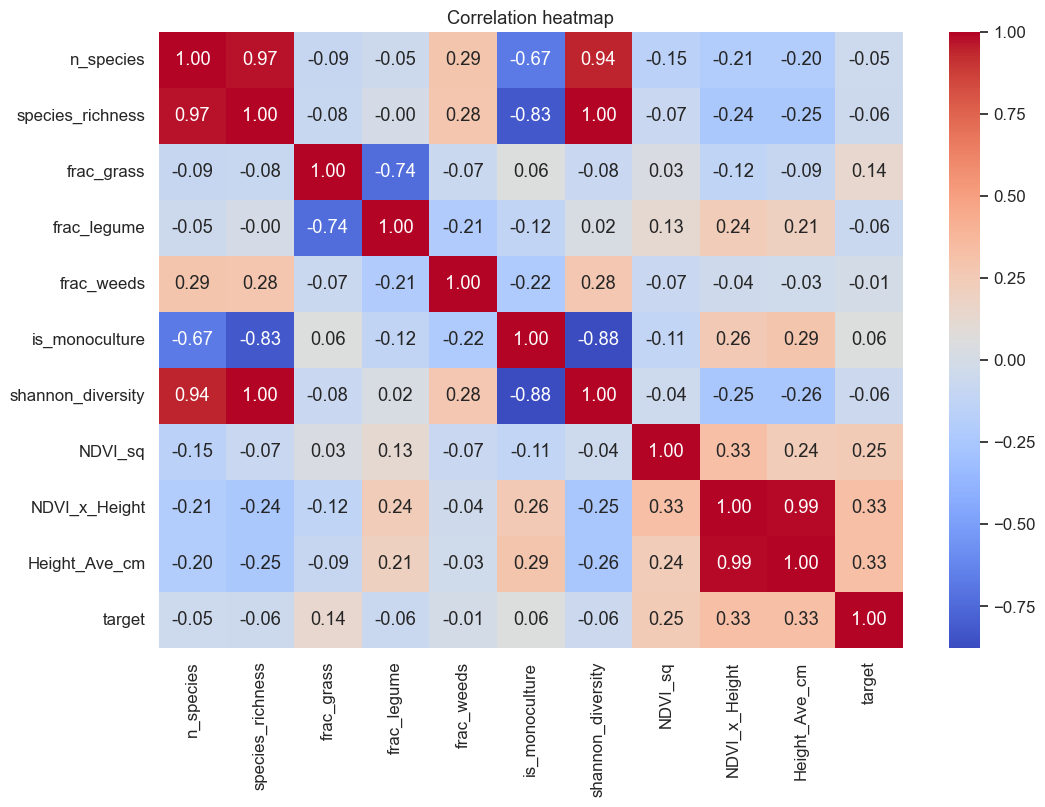

In [20]:
plt.figure(figsize=(12,8))
corr = df_fe[num_features + ['target']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation heatmap")
plt.show()


Insights:

NDVI_x_Height has highest correlation with biomass → best single predictor.

has_grass positively correlated; has_legume mild positive.

species_richness and shannon_diversity slightly positive — supports ecological productivity link.

month_sin, month_cos mild correlation → confirms seasonal variation.

Model implication:
We can prioritize NDVI_x_Height and structural-vegetation interaction terms in baseline tabular or hybrid models.

In [29]:
cat_features = [col for col in df.columns if col.startswith('dom_') or col.startswith('top_') or col.startswith('State_')]

plt.figure(figsize=(15,8))
for i, col in enumerate(cat_features):
    plt.subplot(3,4,i+1)
    sns.boxplot(x=df_fe[col], y=df_fe['target'])
    plt.title(col)
plt.tight_layout()
plt.show()


<Figure size 1500x800 with 0 Axes>

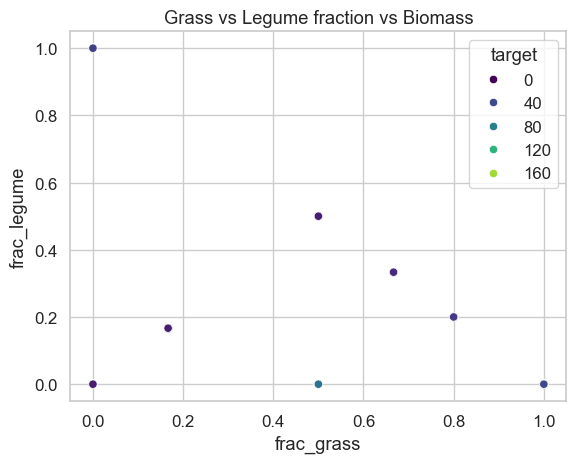

In [26]:
sns.scatterplot(x=df_fe['frac_grass'], y=df_fe['frac_legume'], hue=df_fe['target'], palette='viridis')
plt.title("Grass vs Legume fraction vs Biomass")
plt.show()


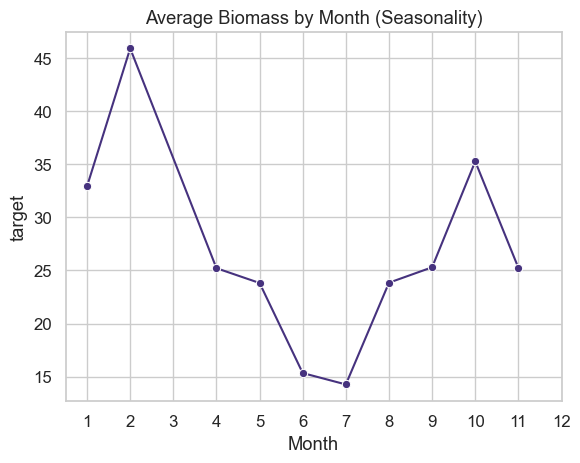

In [32]:
# sns.scatterplot(x=df_fe['month_sin'], y=df_fe['target'], hue=df_fe['month_cos'], palette='coolwarm')
# plt.title("Seasonality effect on Biomass")
# plt.show()
#df_fe['month'] = df_fe['date'].dt.month  # if you have date
month_mean = df_fe.groupby('Month')['target'].mean().reset_index()

sns.lineplot(data=month_mean, x='Month', y='target', marker='o')
plt.xticks(range(1,13))
plt.title("Average Biomass by Month (Seasonality)")
plt.show()


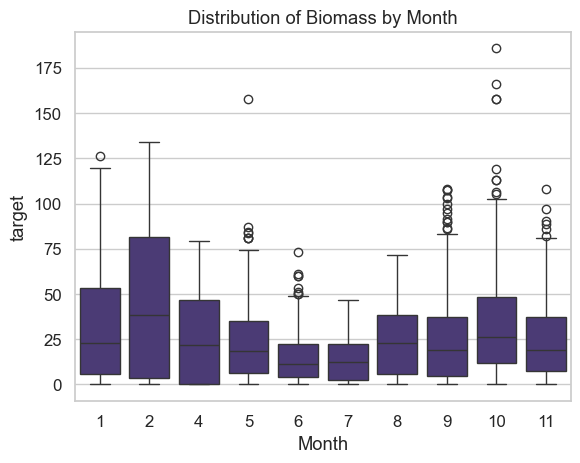

In [33]:
sns.boxplot(x='Month', y='target', data=df_fe)
plt.title("Distribution of Biomass by Month")
plt.show()


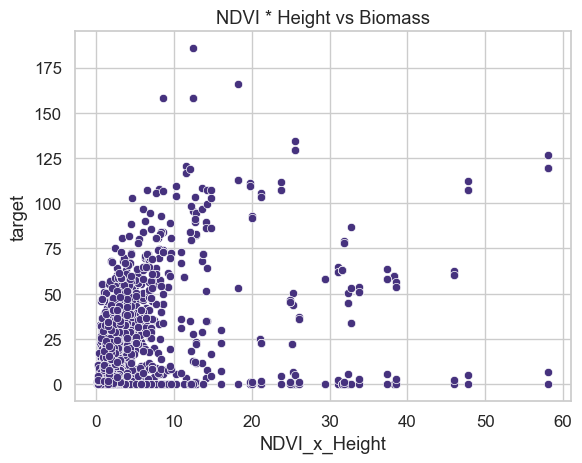

In [28]:
sns.scatterplot(x=df_fe['NDVI_x_Height'], y=df_fe['target'])
plt.title("NDVI * Height vs Biomass")
plt.show()


Next EDA: Image-level analysis

Compute mean RGB, green index (G−R)/(G+R), vegetation cover ratio.

Correlate with NDVI and target to confirm alignment.

Visualize differences by dominant species.

Quantify strongest drivers
Check Pearson/Spearman correlation for NDVI_x_Height, frac_grass, frac_legume, month_sin, etc.

To train model with external data then finetuned on competition data
check model is learning which features 